This notebook a classifier of Structural Magnetic Resonance Imaging (MRI) for Alzheimer Disease identification using convolutional Neural Networks and  Transfer Learning to predict the condition (non-dementia, moderate dementia, very mild dementia, mild dementia) associated with the brain captured in MRI images.


Transfer Learning  is an excellence approach for problems where there isn't a large amount of data. Using pre-trained models helps us increase our accuracy, since these models are trained on datasets with millions of images. 


### Importing data

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"belbellajwiame","key":"08aa0ba7aaf87dd1e1e5388cd4184177"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images
!mkdir /content/alzheimers-dataset
!cp alzheimers-dataset-4-class-of-images.zip /content/alzheimers-dataset
%cd /content/alzheimers-dataset
!unzip  alzheimers-dataset-4-class-of-images.zip 
%cd ..

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem219.jpg  
  inflating: Alzheimer_s D

### Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Preprocessing DATA(data augmentation)

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [18]:
train_dataset  = train_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 60)

Found 4098 images belonging to 4 classes.


In [19]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 60)

Found 254 images belonging to 4 classes.


### Data Visualization





100%|██████████| 5/5 [00:12<00:00,  2.57s/it]


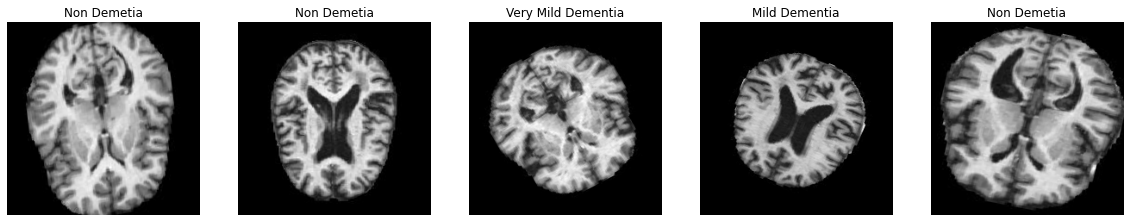

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### Model Initialization
Importing pre-trained model and adding dense layers

In [7]:
#we import DenseNet169 model without its last layer
base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")
#DenseNet-169 was chosen because despite having a depth of 169 layers it is relatively low in parameters compared to other models
#and the architecture handles the vanish gradient problem well.

51879936/51877672 [==============================] - 0s 0us/step


### Freezing layers


In [ ]:
#Since we do not have a large dataset, we will set all the base model's parameters as non trainable and use the pre-trained network weights as initialisers
for layer in base_model.layers:
    layer.trainable=False

### build model


In [8]:
#Next we make a model based on base_model, add some layers and softmax layers.
# Start a new Keras Sequential model.
model=Sequential()
model.add(base_model)
# Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data 
model.add(Dropout(0.5))
# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
model.add(Flatten())
model.add(BatchNormalization())
# Add a dense (aka. fully-connected) layer.
# This is for combining features that the Densenet169 model has recognized in the image.
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Add the final layer for the actual classification.
model.add(Dense(4,activation='softmax'))

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1664)        0         
_________________________________________________________________
flatten (Flatten)            (None, 81536)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 81536)             326144    
_________________________________________________________________
dense (Dense)                (None, 2048)              166987776 
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [ ]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()

True:	densenet169
True:	dropout
True:	flatten
True:	batch_normalization
True:	dense
True:	batch_normalization_1
True:	activation
True:	dropout_1
True:	dense_1
True:	batch_normalization_2
True:	activation_1
True:	dropout_2
True:	dense_2


### compile model


In [9]:
# We compile the models using adam as optimizer, categorical cross entropy as loss function and accuracy as evaluation metric
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
33/33 [==============================] - 69s 2s/step - loss: 1.5848 - auc: 0.7267 - val_loss: 6.0041 - val_auc: 0.6961

Epoch 00001: val_auc improved from -inf to 0.69606, saving model to ./best_weights.hdf5
Epoch 2/500
33/33 [==============================] - 49s 1s/step - loss: 1.0751 - auc: 0.8357 - val_loss: 1.5557 - val_auc: 0.8229

Epoch 00002: val_auc improved from 0.69606 to 0.82292, saving model to ./best_weights.hdf5
Epoch 3/500
33/33 [==============================] - 49s 1s/step - loss: 1.0028 - auc: 0.8464 - val_loss: 1.0668 - val_auc: 0.8570

Epoch 00003: val_auc improved from 0.82292 to 0.85704, saving model to ./best_weights.hdf5
Epoch 4/500
33/33 [==============================] - 49s 1s/step - loss: 0.9859 - auc: 0.8531 - val_loss: 0.8420 - val_auc: 0.8776

Epoch 00004: val_auc improved from 0.85704 to 0.87762, saving model to ./best_weights.hdf5
Epoch 5/500
33/33 [==============================] - 50s 1s/step - loss: 0.8765 - auc: 0.8726 - val_loss: 0.817

### model evaluation

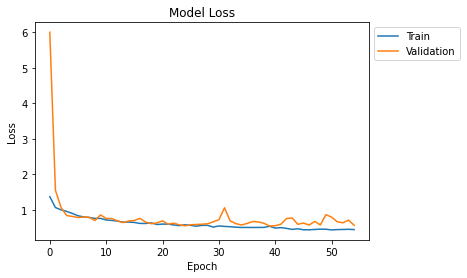

In [ ]:

# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


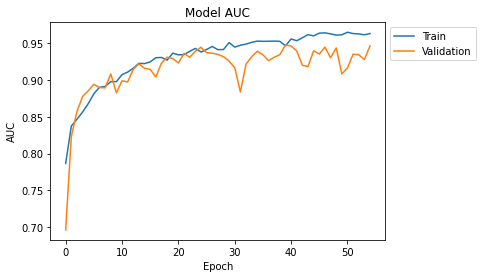

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [30]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['val_auc']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_auc']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.gca().set_ylim(0, 1)

    plt.show()

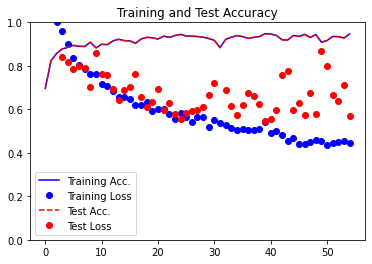

In [ ]:
plot_training_history(model_history)

In [38]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

10/10 [==============================] - 5s 446ms/step - loss: 1.0428 - auc: 0.8881


In [20]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../content/alzheimers-dataset/Alzheimer_s Dataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 60)

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 7s 745ms/step - loss: 1.0428 - auc: 0.8881


[1.0427947044372559, 0.8880622386932373]

In [ ]:
result = model.evaluate(test_dataset)

10/10 [==============================] - 5s 444ms/step - loss: 1.0428 - auc: 0.8881


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


99.57 % chances are there that the image is NonDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


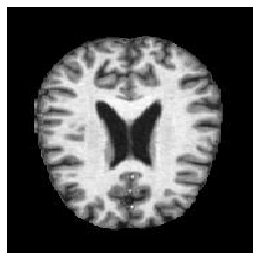

In [ ]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

88.7 % chances are there that the image is MildDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


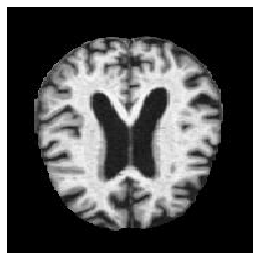

In [ ]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

99.85 % chances are there that the image is ModerateDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


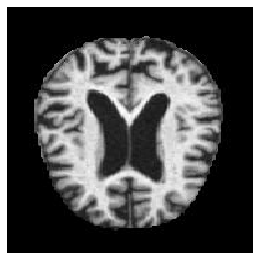

In [ ]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

97.01 % chances are there that the image is VeryMildDemented


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


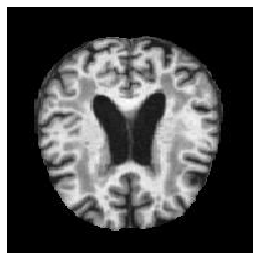

In [ ]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('../content/alzheimers-dataset/Alzheimer_s Dataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict_classes(img)
probability = round(np.max(model.predict_proba(img)*100),2)

print(probability, '% chances are there that the image is',idc[answer[0]])

In [33]:
cls_train = valid_dataset.classes
cls_test = valid_dataset.classes
batch_size = 20
steps_test = valid_dataset.n / batch_size
steps_test


12.7

In [40]:
class_names = list(valid_dataset.class_indices.keys())
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
y_pred = model.predict(valid_dataset, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
print_confusion_matrix(cls_pred)

Confusion matrix:
[[ 3  0 23  9]
 [ 0  1  0  1]
 [15  0 84 29]
 [15  1 52 21]]
(0) MildDemented
(1) ModerateDemented
(2) NonDemented
(3) VeryMildDemented


In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 88.81%
